In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import os
import glob

In [2]:
df, muta = [pd.read_csv(file_) for file_ in glob.glob(os.path.join('../data/', '*'))]

### Missing Values

In [21]:
df.isna().mean() * 100

GISAID ID                     0.060680
Unnamed: 1                  100.000000
Virus name                    0.060680
FECHA DE COLECCIÓN            0.060680
FECHA DE SUBIDA A GISAID      0.060680
PROVINCIA                     0.060680
CIUDAD                        0.242718
TIPO                          0.910194
Genero                        0.060680
Edad                          0.060680
Linaje                        0.060680
Clado                         0.060680
Mutaciones                    0.060680
dtype: float64

In [22]:
muta.isna().mean() * 100

0I (Alpha, V1) (B.1.1.7)        78.181818
20H (Beta, V2) (B.1.351)        80.000000
20J (Gamma, V3) (P.1)           78.181818
21A (Delta) (B.1.617.2)         83.636364
21B (Kappa) (B.1.617.1)         89.090909
21K (Omicron) (BA.1)            34.545455
21L (Omicron) (BA.2)            43.636364
22A & 22B (Omicron) (BA.4&5)    38.181818
22C (Omicron) (BA.2.12.1)       40.000000
21D (Eta) (B.1.525)             83.636364
21F (Iota) (B.1.526)            89.090909
21G (Lambda) (C.37)             74.545455
21H (Mu) (B.1.621)              83.636364
dtype: float64

### Memory Usage

In [23]:
(df
 .memory_usage(deep=True)
 .pipe(lambda df_:pd.concat([df_, df.dtypes], axis=1))
 .rename(columns={0:'memory', 1:'dtype'})
)

,memory,dtype
Index,128,NaN
GISAID ID,119098,object
Unnamed: 1,13184,float64
Virus name,143752,object
FECHA DE COLECCIÓN,110114,object
FECHA DE SUBIDA A GISAID,110381,object
PROVINCIA,110907,object
CIUDAD,106642,object
TIPO,109197,object
Genero,102496,object


### The Data

In [5]:
df.sample(10)

,GISAID ID,Unnamed: 1,Virus name,FECHA DE COLECCIÓN,FECHA DE SUBIDA A GISAID,PROVINCIA,CIUDAD,TIPO,Genero,Edad,Linaje,Clado,Mutaciones
493,EPI_ISL_3133384,NaN,hCoV-19/Ecuador/USFQ-1712/2021,2021-07-15,2021-07-29,Manabi,MANTA,Hospital,Male,65,C.37,GR,"(Spike_L249del,Spike_S247del,Spike_G75V,Spike_..."
1210,EPI_ISL_11012618,NaN,hCoV-19/Ecuador/USFQ-2904/2022,2022-02-04,2022-03-14,Pichincha,QUITO,Ambulatorio,Female,unknown,BA.1.1,GRA,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V..."
958,EPI_ISL_9489212,NaN,hCoV-19/Ecuador/USFQ-2608/2022,2022-01-14,2022-02-04,Imbabura,IBARRA,Hospital,Female,unknown,BA.1.1,GRA,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V..."
1441,EPI_ISL_11515625,NaN,hCoV-19/Ecuador/USFQ-3165/2022,2022-03-02,2022-03-28,Esmeraldas,Esmeraldas,Hospital,Female,unknown,Unassigned,G,"(NSP5_P132H,NSP6_L105del,NSP6_G107del,NSP6_S10..."
67,EPI_ISL_539788,NaN,hCoV-19/Ecuador/USFQ-216/2020,2020-08-05,2020-09-20,Azuay,Cuenca,Ambulatorio,Male,66,B.1.223,G,"(NSP3_S166G,NSP12_M666I,NSP3_F90L,NSP12_P323L,..."
7,EPI_ISL_471270,NaN,hCoV-19/Ecuador/USFQ-112/2020,2020-05-19,2020-06-19,Pichincha,QUITO,NaN,Female,unknown,B.1.1,GR,"(N_R203K,N_G204R,NSP12_P323L,NS3_Q185H,Spike_D..."
76,EPI_ISL_660530,NaN,hCoV-19/Ecuador/USFQ-230/2020,2020-10-01,2020-11-26,Tungurahua,AMBATO,Hospital,Female,25,B.1.1.10,GR,"(N_R203K,N_G204R,NSP12_P323L,Spike_D614G)"
413,EPI_ISL_2861151,NaN,hCoV-19/Ecuador/USFQ-1594/2021,2021-06-21,2021-07-08,Morona Santiago,MACAS,Hospital,Male,unknown,A,O,"(Spike_S477N,NSP6_G107del,NSP6_S106del,NSP6_F1..."
113,EPI_ISL_824288,NaN,hCoV-19/Ecuador/USFQ-570/2020,2020-12-28,2021-01-14,Santo Domingo,Santo Domingo,Hospital,Female,32,B.1.1.348,GR,"(N_T366I,NSP16_M270I,Spike_G1167A,N_R203K,N_G2..."
1108,EPI_ISL_10801173,NaN,hCoV-19/Ecuador/USFQ-2754/2022,2022-01-28,2022-03-08,Pichincha,QUITO,Ambulatorio,Female,unknown,BA.1.1,GRA,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V..."


In [25]:
muta.head()

,"0I (Alpha, V1) (B.1.1.7)","20H (Beta, V2) (B.1.351)","20J (Gamma, V3) (P.1)",21A (Delta) (B.1.617.2),21B (Kappa) (B.1.617.1),21K (Omicron) (BA.1),21L (Omicron) (BA.2),22A & 22B (Omicron) (BA.4&5),22C (Omicron) (BA.2.12.1),21D (Eta) (B.1.525),21F (Iota) (B.1.526),21G (Lambda) (C.37),21H (Mu) (B.1.621)
0,Principales mutaciones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G,S:D614G
2,NaN,S:E484K,S:E484K,NaN,S:E484Q,S:E484A,S:E484A,S:E484A,S:E484A,S:E484K,S:E484K,NaN,S:E484K
3,S:P681H,NaN,NaN,S:P681R,S:P681R,S:P681H,S:P681H,S:P681H,S:P681H,NaN,NaN,NaN,S:P681H
4,S:N501Y,S:N501Y,S:N501Y,NaN,NaN,S:N501Y,S:N501Y,S:N501Y,S:N501Y,NaN,NaN,NaN,S:N501Y


### Numerical Types

### Non-Numeric Types

### Datetimes

### Tweak pd.DataFrames

In [4]:
def check_memory(df):
    print(df.memory_usage(deep=True).sum() / 1000000)
    return df

def get_shape(df):
    print(df.shape)
    return df

(df
 .drop(columns=['Unnamed: 1', 'FECHA DE SUBIDA A GISAID', 'GISAID ID'])
 .applymap(lambda tx: unidecode(tx.lower()) if isinstance(tx, str) else tx)
 .rename(columns=lambda c: c.replace(' ', '_').lower())
 .assign(virus_name = lambda df_: (df_
                                   .virus_name
                                   .str
                                   .split('/', expand=True)
                                   .loc[:, 2]),
         linaje1 = lambda df_: df_.linaje.str.split('.')
        )
 # .sample(5)
)


,virus_name,fecha_de_colección,provincia,ciudad,tipo,genero,edad,linaje,clado,mutaciones,linaje1
0,hee-01,2020-03-09,pichincha,quito,hospital,male,57,b.55,l,spike e1207v,"[b, 55]"
1,hgsq-usfq-018,2020-03-30,pichincha,quito,hospital,male,27,b.1.1,gr,"(n_r203k,n_g204r,nsp12_p323l,nsp3_l431f,spike_...","[b, 1, 1]"
2,hgsq-usfq-007,2020-03-30,pichincha,quito,hospital,male,40,b.1.14,o,"(nsp15_s293t,ns3_q38p,ns3_v163t,ns3_r122e,ns3_...","[b, 1, 14]"
3,hgsq-usfq-010,2020-03-30,pichincha,quito,hospital,male,39,b.1.14,o,"(nsp15_s293t,ns3_q38p,ns3_v163t,ns3_r122e,ns3_...","[b, 1, 14]"
4,usfq-020,2020-04-17,los rios,babahoyo,hospital,female,50,b.1.67,g,"(nsp12_p323l,spike_d614g)","[b, 1, 67]"
...,...,...,...,...,...,...,...,...,...,...,...
1643,usfq-3477,2022-05-27,pichincha,quito,ambulatorio,male,42,ba.2,gra,"(nsp5_p132h,nsp3_g489s,nsp4_t327i,spike_s373p,...","[ba, 2]"
1644,usfq-3479,2022-05-28,pichincha,quito,ambulatorio,male,54,ba.2,gra,"(nsp5_p132h,nsp3_g489s,spike_l24del,nsp4_t327i...","[ba, 2]"
1645,usfq-3482,2022-05-29,pichincha,quito,ambulatorio,male,5,ba.2,gra,"(nsp5_p132h,nsp3_g489s,nsp4_t327i,spike_s373p,...","[ba, 2]"
1646,usfq-3483,2022-05-25,pichincha,quito,ambulatorio,male,34,ba.2,gra,"(nsp5_p132h,spike_s371f,nsp3_g489s,nsp13_r392c...","[ba, 2]"


In [5]:
(df
 .drop(columns=['Unnamed: 1', 'FECHA DE SUBIDA A GISAID', 'GISAID ID'])
 .applymap(lambda tx: unidecode(tx.lower()) if isinstance(tx, str) else tx)
 .rename(columns=lambda c: c.replace(' ', '_').lower())
 .virus_name.str.split('/', expand=True)
 .loc[:, 2]
 # .assign()
 # .sample(5)
)


0              hee-01
1       hgsq-usfq-018
2       hgsq-usfq-007
3       hgsq-usfq-010
4            usfq-020
            ...      
1643        usfq-3477
1644        usfq-3479
1645        usfq-3482
1646        usfq-3483
1647        usfq-3484
Name: 2, Length: 1648, dtype: object

### Diccionario de variantes


In [6]:
df.columns

Index(['GISAID ID', 'Unnamed: 1', 'Virus name', 'FECHA DE COLECCIÓN',
       'FECHA DE SUBIDA A GISAID', 'PROVINCIA', 'CIUDAD', 'TIPO', 'Genero',
       'Edad', 'Linaje', 'Clado', 'Mutaciones'],
      dtype='object')

In [7]:
df['Linaje']=df['Linaje'].astype(str)

In [8]:
import re

cadena = ','.join(muta.columns)

# Dividir la cadena en substrings utilizando la coma como separador
substrings = cadena.split(',')

# Inicializar el diccionario
diccionario = {}

# Recorrer cada substring y extraer la variante y el linaje
for substring in substrings:
    # Extraer la variante y el linaje utilizando expresiones regulares
    matches = re.findall(r'(\w+ \([\w\s]+\)) \(([\w\.&]+)\)', substring)
    if matches:
        # Almacenar la variante y el linaje en el diccionario
        variante, linaje = matches[0]
        diccionario[variante] = linaje

print(diccionario)

{'21A (Delta)': 'B.1.617.2', '21B (Kappa)': 'B.1.617.1', '21K (Omicron)': 'BA.1', '21L (Omicron)': 'BA.2', '22B (Omicron)': 'BA.4&5', '22C (Omicron)': 'BA.2.12.1', '21D (Eta)': 'B.1.525', '21F (Iota)': 'B.1.526', '21G (Lambda)': 'C.37', '21H (Mu)': 'B.1.621'}


In [37]:
# Supongamos que el dataframe se llama "df"
# Y que el diccionario se llama "diccionario"

# Creamos la nueva columna con valores vacíos
diccionario['22B (Omicron)']='BA.5'
diccionario['22A (Omicron)']='BA.4'
print (diccionario)


{'21A (Delta)': 'B.1.617.2', '21B (Kappa)': 'B.1.617.1', '21K (Omicron)': 'BA.1', '21L (Omicron)': 'BA.2', '22B (Omicron)': 'BA.5', '22C (Omicron)': 'BA.2.12.1', '21D (Eta)': 'B.1.525', '21F (Iota)': 'B.1.526', '21G (Lambda)': 'C.37', '21H (Mu)': 'B.1.621', '22A (Omicron)': 'BA.4'}


In [70]:
#Recorrer cada row del dataframe obtener el valor de la columna linaje
for row, value in df.iterrows():

# comparar el valor de la columna linaje con el diccionario
# si el valor de la columna linaje esta en el diccionario
# asignar el valor de la columna Variante con el valor del diccionario
# si el valor de la columna linaje no esta en el diccionario
# asignar el string 'desconocido'
if value['linaje'] in diccionario.values()   :
    df['variante'][row] = value['linaje']
    
else:
    df['Variante'][row] = 'desconocido'

df['Variante'].value_counts()

IndentationError: expected an indented block after 'for' statement on line 2 (1314332341.py, line 9)

### Data visualization
#### Clados por Provincia


In [11]:
import matplotlib.pyplot as plt

In [9]:
df.columns

Index(['GISAID ID', 'Unnamed: 1', 'Virus name', 'FECHA DE COLECCIÓN',
       'FECHA DE SUBIDA A GISAID', 'PROVINCIA', 'CIUDAD', 'TIPO', 'Genero',
       'Edad', 'Linaje', 'Clado', 'Mutaciones'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GISAID ID                 1647 non-null   object 
 1   Unnamed: 1                0 non-null      float64
 2   Virus name                1647 non-null   object 
 3   FECHA DE COLECCIÓN        1647 non-null   object 
 4   FECHA DE SUBIDA A GISAID  1647 non-null   object 
 5   PROVINCIA                 1647 non-null   object 
 6   CIUDAD                    1644 non-null   object 
 7   TIPO                      1633 non-null   object 
 8   Genero                    1647 non-null   object 
 9   Edad                      1647 non-null   object 
 10  Linaje                    1648 non-null   object 
 11  Clado                     1647 non-null   object 
 12  Mutaciones                1647 non-null   object 
dtypes: float64(1), object(12)
memory usage: 167.5+ KB


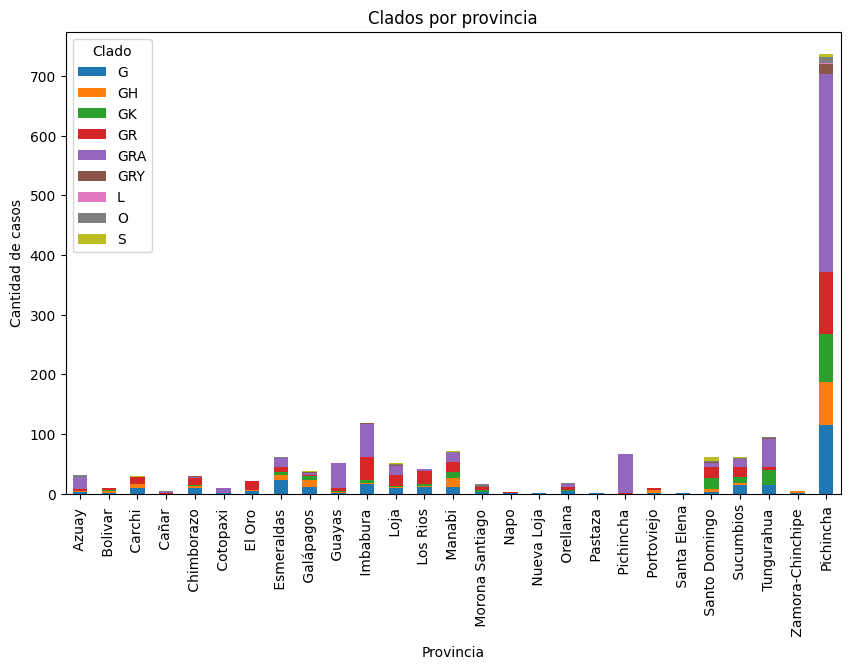

In [21]:
grouped=df.groupby('PROVINCIA')['Clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clados por provincia')
ax.set_xlabel('Provincia')
ax.set_ylabel('Cantidad de casos')

plt.show()

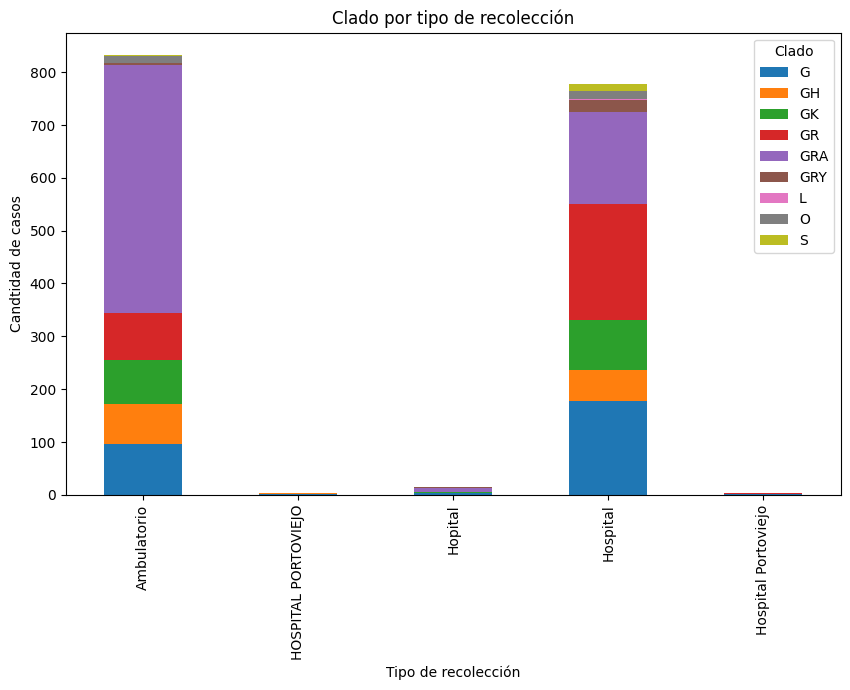

In [18]:
grouped=df.groupby('TIPO')['Clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clado por tipo de recolección')
ax.set_xlabel('Tipo de recolección')
ax.set_ylabel('Candtidad de casos')

plt.show()

Text(0, 0.5, 'Genero')

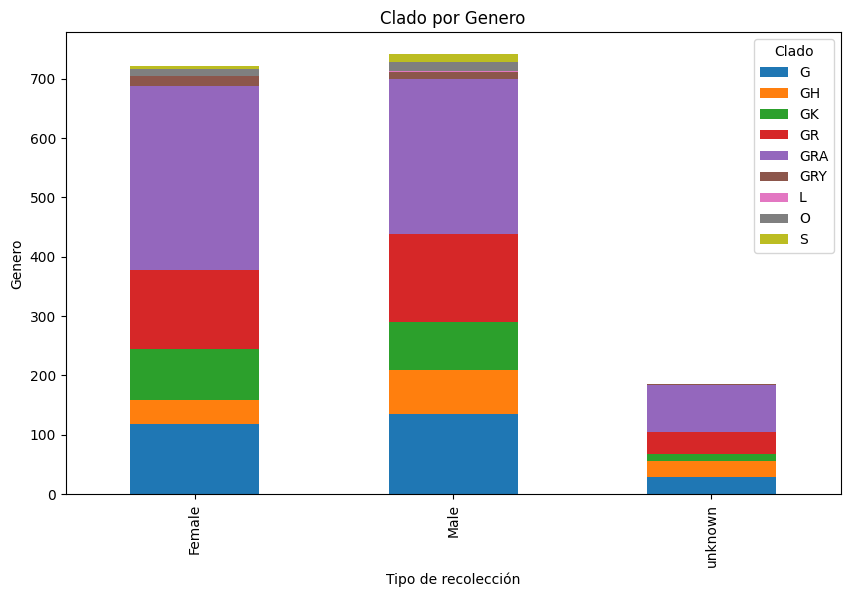

In [20]:
grouped=df.groupby('Genero')['Clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clado por Genero')
ax.set_xlabel('Tipo de recolección')
ax.set_ylabel('Genero')

In [25]:
grouped=df.groupby('Mutaciones')['Clado'].value_counts().unstack()
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Clado por Genero')
ax.set_xlabel('Tipo de recolección')
ax.set_ylabel('Genero')

### Anomalies

#### Cleanup Round Brainstorm
- Drop Unnamed: 1 ; FECHA DE SUBIDA A GISAID ; GISAID ID
- Split `Virus name` and remove first two elements
- FECHA DE COLECCION apply pd.to_datetime()
- rewrite columns names to make them valid keywords (lowercase and underscore instead of whitespace) 
- decode text data and transform to lowercase
- Edad ; Genero must contain np.nan instead of unknown
- Cambiar provincias protoviejo y nueva loja a manabi y sucumbios


